In [50]:
import pandas as pd
import numpy as np 
import itertools
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest

### Preprocessing data

In [62]:
data_c = pd.read_parquet('./Local/2017_Clean/Combined.parquet')
data_f1 = pd.read_parquet('./Local/2017_Final/Combined_1.parquet')
data_f2 = pd.read_parquet('./Local/2017_Final/Combined_2.parquet')

datasets = {'Clean data': data_c, 'Final data 1': data_f1, 'Final data 2': data_f2}
matrices = {}
roc_data = {}

print(data_f2['Label'].value_counts())

Label
BENIGN                        4293798
DoS Hulk                       345692
DDoS                           256028
PortScan                       181388
DoS GoldenEye                   20572
FTP-Patator                     11862
DoS slowloris                   10770
DoS Slowhttptest                10456
SSH-Patator                      6438
Bot                              3896
Web Attack � Brute Force         2940
Web Attack � XSS                 1304
Infiltration                       72
Web Attack � Sql Injection         42
Heartbleed                         22
Name: count, dtype: int64


In [35]:
def preprocess_data(df):
        
    if 'Label' in df.columns:
        label_col = 'Label'
    elif ' Label' in df.columns:
        label_col = ' Label'
    else:
        raise ValueError("DataFrame does not contain a label column")
    
    X = df.drop(label_col, axis=1)
    y = df[label_col]
    y = y.apply(lambda x: 0 if x != 'BENIGN' else 1)

    return X, y

processed_datasets = {name: preprocess_data(df) for name, df in datasets.items()}

### Running Isolation Forest for each dataset

In [63]:
# Tmp solution, sth is wrong with this
import warnings
warnings.filterwarnings("ignore")

for name, (X, y) in processed_datasets.items():
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    iso_forest = IsolationForest(n_estimators=100, max_samples='auto', contamination=0.05, random_state=0)
    iso_forest.fit(X_train_scaled)

    y_score = -iso_forest.decision_function(X_test_scaled)
    fpr, tpr, _ = metrics.roc_curve(y_test, y_score)
    roc_auc = metrics.auc(fpr, tpr)
    roc_data[name] = (fpr, tpr, roc_auc)

    y_pred = iso_forest.predict(X_test_scaled)
    y_pred = np.where(y_pred == -1, 0, 1)

    num_outliers = np.count_nonzero(y_pred == 0)
    num_inliers = np.count_nonzero(y_pred == 1)

    print(f'--- {name} ---')
    print(f"Number of outliers detected: {num_outliers}")
    print(f"Number of normal samples detected: {num_inliers}")
    print("Accuracy: {}".format(metrics.accuracy_score(y_test, y_pred)))

    print("Classification Report:")
    labels = ['Attack', 'Benign']
    print(metrics.classification_report(y_test, y_pred, target_names=labels))
    print('\n')

    cm = metrics.confusion_matrix(y_test, y_pred)
    matrices[name] = cm 

--- Clean data ---
Number of outliers detected: 26085
Number of normal samples detected: 488443
Accuracy: 0.050696949437154054
Classification Report:
              precision    recall  f1-score   support

      Attack       1.00      0.05      0.10    514528
      Benign       0.00      0.00      0.00         0

    accuracy                           0.05    514528
   macro avg       0.50      0.03      0.05    514528
weighted avg       1.00      0.05      0.10    514528



--- Final data 1 ---
Number of outliers detected: 51054
Number of normal samples detected: 978002
Accuracy: 0.049612460352011944
Classification Report:
              precision    recall  f1-score   support

      Attack       1.00      0.05      0.09   1029056
      Benign       0.00      0.00      0.00         0

    accuracy                           0.05   1029056
   macro avg       0.50      0.02      0.05   1029056
weighted avg       1.00      0.05      0.09   1029056



--- Final data 2 ---
Number of outliers 

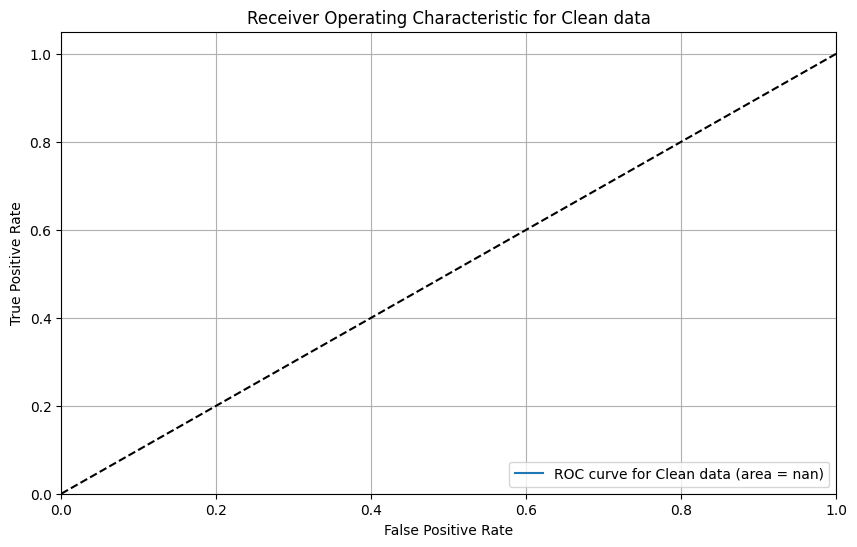

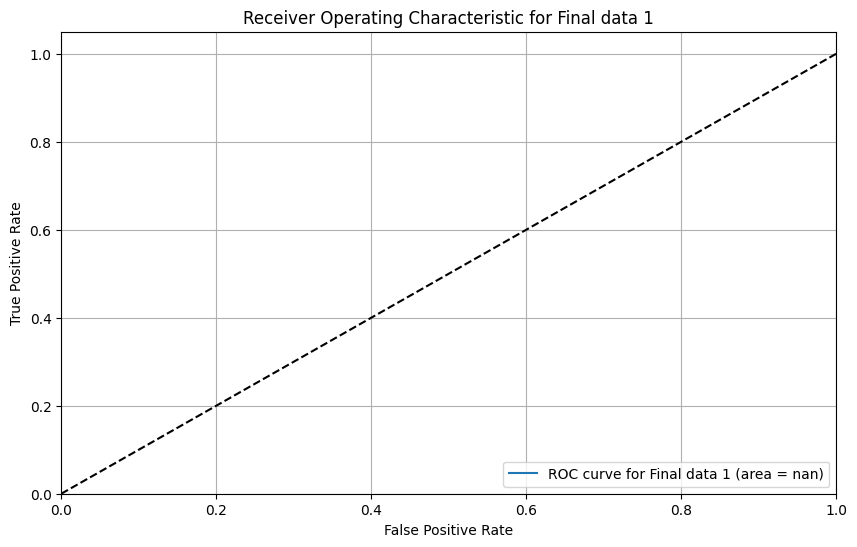

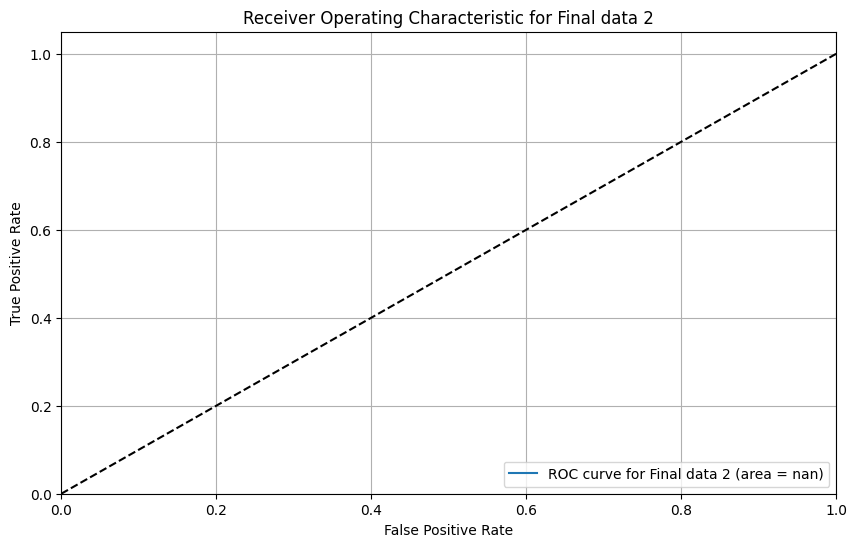

In [66]:
for name, (fpr, tpr, roc_auc) in roc_data.items():
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, label=f'ROC curve for {name} (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic for {name}')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

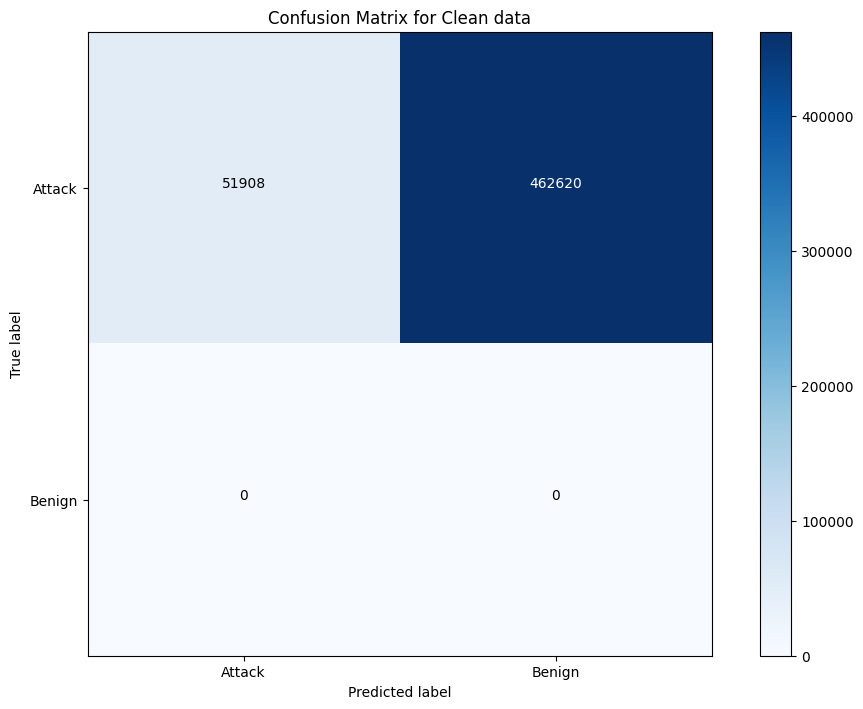

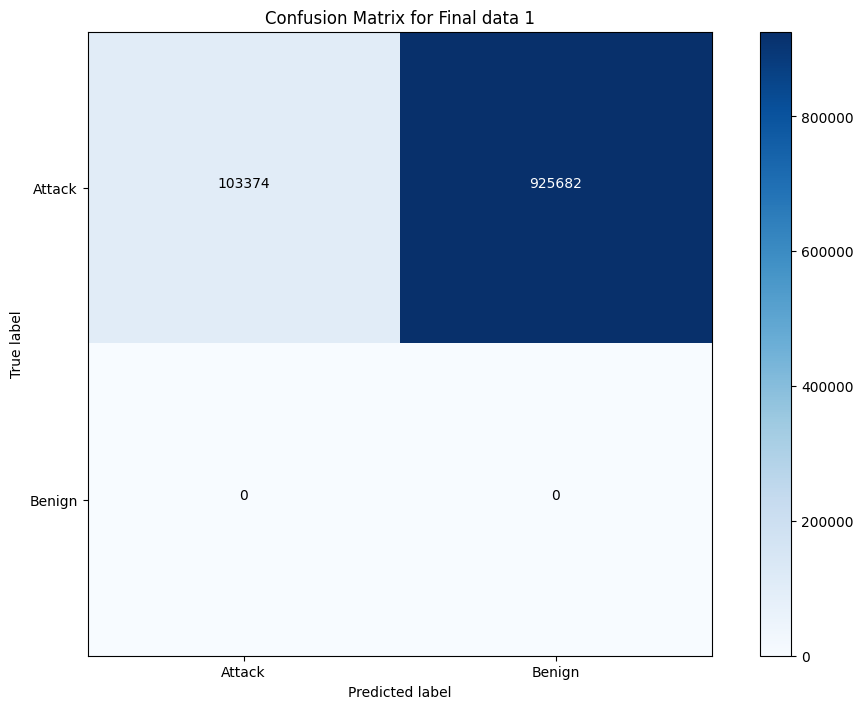

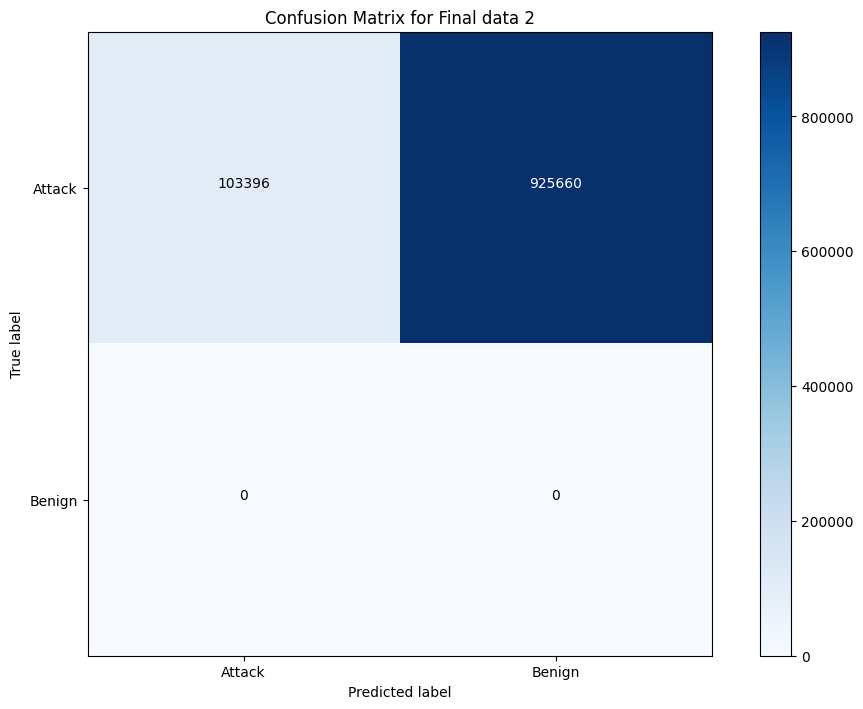

In [53]:
for name, matrix in matrices.items():
    plt.figure(figsize=(10, 7))
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {name}')
    plt.colorbar()
    
    labels = ['Attack', 'Benign']
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels)
    plt.yticks(tick_marks, labels)

    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()